In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import json
import wandb

from src.utils import normalize_curve, compute_integral

In [3]:
results_dir = Path('../data/results/')
opts_dir = Path('../data/interim/')

T = 125
net_id = 'xae9giql'
all_shortnames = {'_'.join(fp.name.split('_')[:3]) for fp in results_dir.glob(f'{net_id}_*_{T}_*.json')}
all_shortnames.add('baseline_bs_0')
all_shortnames
for shortname in sorted(all_shortnames):
    print(shortname)
    print(len(list(results_dir.glob(shortname+f'_{T}_2*.json'))))

baseline_bs_0
60
xae9giql_ef_0.9
60
xae9giql_ef_0.95
60
xae9giql_ef_0.98
60
xae9giql_ef_0.99
60
xae9giql_ef_0.992
60
xae9giql_ef_0.993
60
xae9giql_ef_0.994
58
xae9giql_ef_0.995
60
xae9giql_ef_0.996
60
xae9giql_ef_0.997
60
xae9giql_ef_0.998
60
xae9giql_ef_0.999
60
xae9giql_ef_1000
60
xae9giql_ef_1250
60
xae9giql_ef_1500
60
xae9giql_ef_1750
60
xae9giql_ef_200
60
xae9giql_ef_500
60
xae9giql_ef_750
60
xae9giql_tr_1000
60
xae9giql_tr_200
60
xae9giql_tr_500
60
xae9giql_ws_-1
60
xae9giql_ws_1000
60
xae9giql_ws_500
60


In [4]:
api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
model_name = run.group[len('Best-'):]
model_name

'MultiTarget'

In [25]:
def get_first_feasible(curve):
    try:
        return np.where(curve > 0)[0][0] / 1000
    except IndexError:
        return np.nan

def load_all_results(shortname: str):
    results = list()
    for result_fpath in results_dir.glob(shortname+f'_{T}_2*.json'):
        size = int(result_fpath.name.split('_')[-2])
        size_id = int(result_fpath.name.split('_')[-1][:-len('.json')])

        with open(result_fpath) as f:
            result = json.load(f)

        solution_fpath = opts_dir/f"{T}_{size}_{size_id}_opt.npz"
        solution_npz = np.load(solution_fpath)
        quasi_optimal_objective = solution_npz['arr_0'].astype('uint32')

        results.append(dict(
            size=size,
            size_id=size_id,
            opt_obj=quasi_optimal_objective,
            **result
        ))
    df = pd.DataFrame(results)
    df['primal_curve'] = df['primal_curve'].apply(normalize_curve)
    df['primal_curve'] = df['primal_curve'] / df['opt_obj']

    df['time_to_feasible'] = df['primal_curve'].map(get_first_feasible)
    df['time_to_feasible'][df['infeasible']] = 120

    return df

dfs = {shortname.replace(net_id, model_name): load_all_results(shortname) for shortname in all_shortnames}
# dfs['bs_0'] = dfs['bs_0'][dfs['bs_0']['size'] != 9]

/tmp/ipykernel_631318/24647511.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_to_feasible'][df['infeasible']] = 120
/tmp/ipykernel_631318/24647511.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_to_feasible'][df['infeasible']] = 120
/tmp/ipykernel_631318/24647511.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_to_feasible'][df['infeasible']] = 120
/tmp/ipykernel_631318/24647511.py:31: SettingW

In [26]:
infeasibilities = list()
sns = list()
for sn in dfs.keys():
    df = dfs[sn]
    infeasibility = df['infeasible'].sum() / df.shape[0]

    sns.append(sn)
    infeasibilities.append(infeasibility)

pd.Series(infeasibilities, index=sns, name='infeasibility rate').sort_index()

MultiTarget_ef_0.9      1.000000
MultiTarget_ef_0.95     1.000000
MultiTarget_ef_0.98     0.916667
MultiTarget_ef_0.99     0.350000
MultiTarget_ef_0.992    0.266667
MultiTarget_ef_0.993    0.250000
MultiTarget_ef_0.994    0.233333
MultiTarget_ef_0.995    0.183333
MultiTarget_ef_0.996    0.216667
MultiTarget_ef_0.997    0.200000
MultiTarget_ef_0.998    0.166667
MultiTarget_ef_0.999    0.183333
MultiTarget_ef_1000     0.166667
MultiTarget_ef_1250     0.200000
MultiTarget_ef_1500     0.266667
MultiTarget_ef_1750     0.416667
MultiTarget_ef_200      0.150000
MultiTarget_ef_500      0.216667
MultiTarget_ef_750      0.150000
MultiTarget_tr_1000     0.283333
MultiTarget_tr_200      0.366667
MultiTarget_tr_500      0.316667
MultiTarget_ws_-1       0.266667
MultiTarget_ws_1000     0.266667
MultiTarget_ws_500      0.283333
baseline_bs_0           0.283333
Name: infeasibility rate, dtype: float64

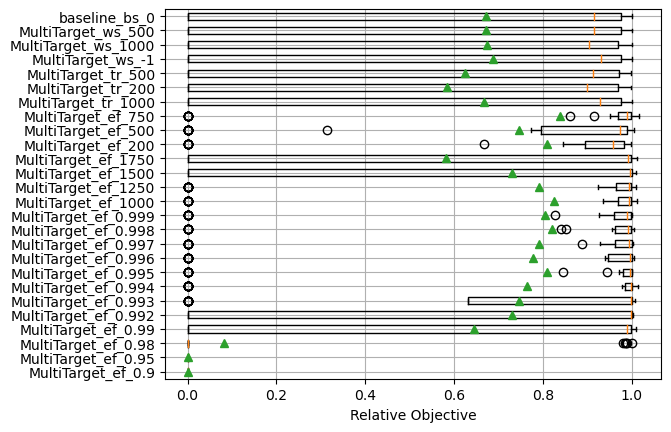

In [27]:
rel_objs = list()
sns = dfs.keys()
sns = sorted(sns)
for sn in sns:
    df = dfs[sn]
    rel_objs.append((df['objective'] / df['opt_obj']).values)
    # (df['objective'] / df['opt_obj']).plot.box(showmeans=True)
plt.boxplot(rel_objs, labels=sns, vert=False, showmeans=True)
# plt.xlim(0.8,1)
plt.xlabel('Relative Objective')
plt.grid()
plt.show()

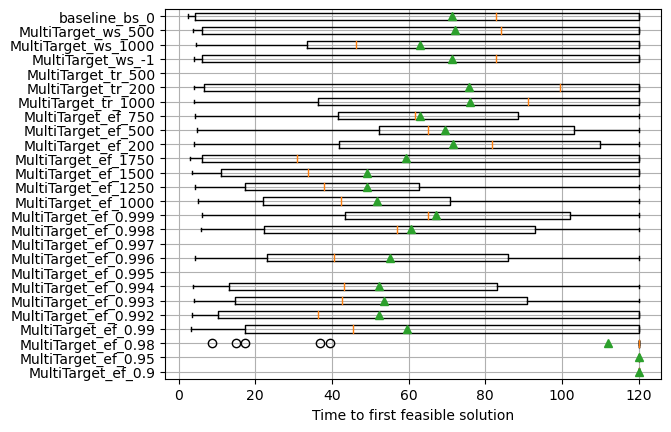

In [29]:
ttfs = list()
for sn in sns:
    df = dfs[sn]
    ttfs.append(df['time_to_feasible'].values)
    # (df['objective'] / df['opt_obj']).plot.box(showmeans=True)
plt.boxplot(ttfs, labels=sns, vert=False, showmeans=True)
# plt.xlim(0.8,1)
plt.xlabel('Time to first feasible solution')
plt.grid()
plt.show()

In [30]:
for n in [200, 1500, 0.9, 0.95, 0.98]:
    sns.pop(sns.index('MultiTarget_ef_'+str(n)))

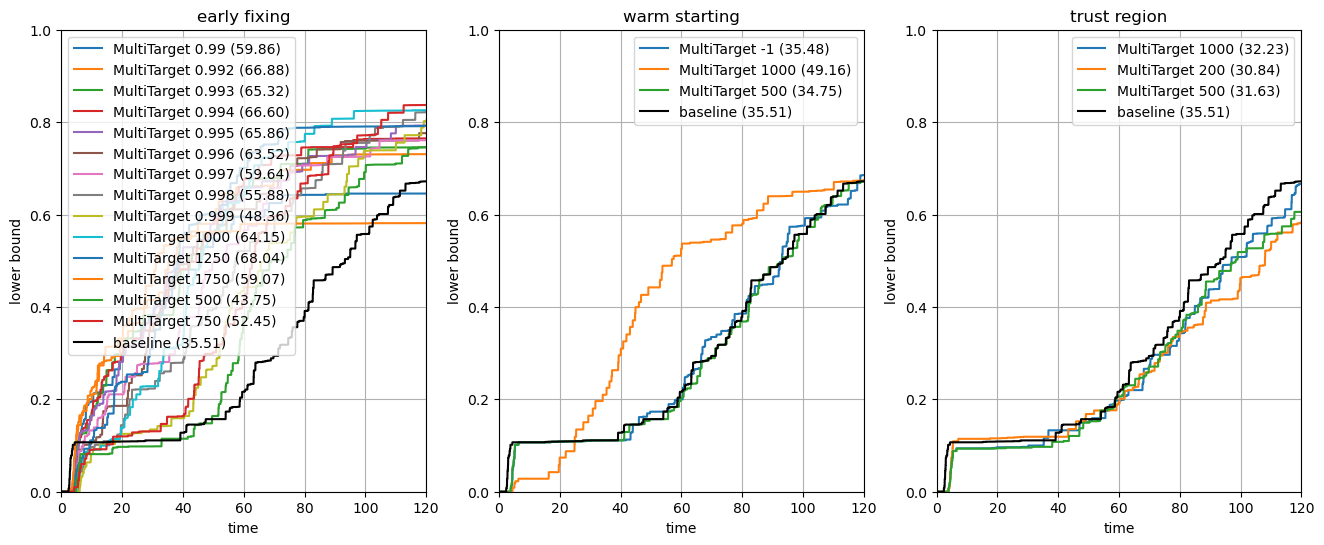

In [31]:
# TODO: baseline is different for every method, as it should take on account the
# feasibility

fig, axs = plt.subplots(1,3)

fig.set_size_inches(16,6)

axs[0].set_title('early fixing')
axs[1].set_title('warm starting')
axs[2].set_title('trust region')

for sn in sns:
    df = dfs[sn]
    dt = 1e-3
    curve = df['primal_curve'].mean()
    auc = np.sum(curve * dt)
    x = np.arange(len(curve)) * dt
    if 'ef' in sn:
        ax = axs[0]
    elif 'ws' in sn:
        ax = axs[1]
    elif 'tr' in sn:
        ax = axs[2]
    else:
        for ax in axs:
            ax.plot(x, curve, color='black', label=f"baseline ({auc:.2f})")
        continue
    ax.plot(x, curve, label=sn.split('_')[0]+' '+sn.split('_')[2]+f" ({auc:.2f})")
    ax.set_ylabel('lower bound')
    ax.set_xlabel('time')
# plt.plot(df[~df['infeasible']]['primal_curve'].mean())

for ax in axs:
    ax.set_xlim(0,120)
    ax.set_ylim(0,1)
    ax.legend()
    ax.grid()
plt.show()

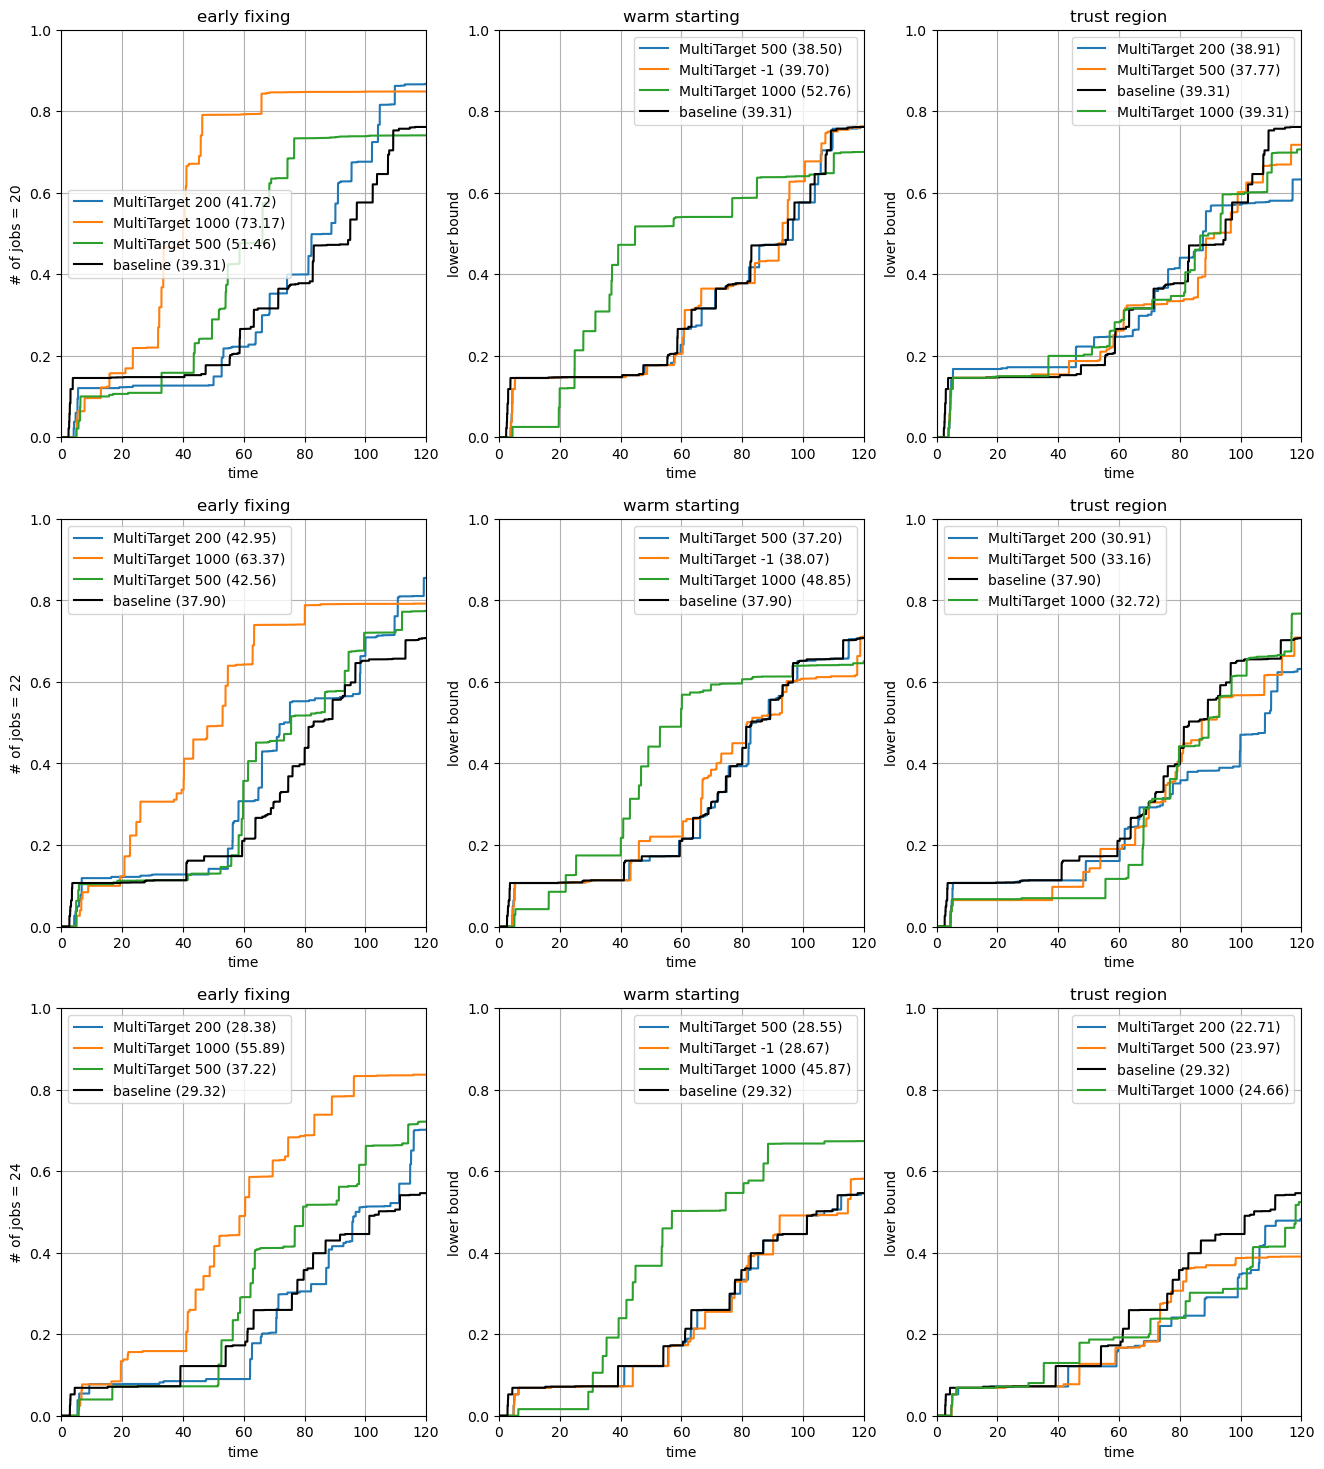

In [10]:
# TODO: baseline is different for every method, as it should take on account the
# feasibility

sizes = sorted(dfs['baseline_bs_0']['size'].unique())

fig, axss = plt.subplots(len(sizes),3)

fig.set_size_inches(16,len(sizes) * 6)

for i, s in enumerate(sizes):
    axs = axss[i]

    axs[0].set_title('early fixing')
    axs[1].set_title('warm starting')
    axs[2].set_title('trust region')

    for sn, df_ in dfs.items():
        df = df_[df_['size'] == s]

        dt = 1e-3
        curve = df['primal_curve'].mean()
        auc = np.sum(curve * dt)
        x = np.arange(len(curve)) * dt

        if 'ef' in sn:
            ax = axs[0]
        elif 'ws' in sn:
            ax = axs[1]
        elif 'tr' in sn:
            ax = axs[2]
        else:
            for ax in axs:
                ax.plot(x, curve, color='black', label=f"baseline ({auc:.2f})")
            continue
        # ax.plot(x, curve, label=sn+f" ({auc:.2f})")
        ax.plot(x, curve, label=sn.split('_')[0]+' '+sn.split('_')[2]+f" ({auc:.2f})")
        ax.set_ylabel('lower bound')
        ax.set_xlabel('time')
    # plt.plot(df[~df['infeasible']]['primal_curve'].mean())

    for ax in axs:
        ax.set_xlim(0,120)
        ax.set_ylim(0,1)
        ax.legend()
        ax.grid()

    axs[0].set_ylabel(f'# of jobs = {s}')
plt.show()